In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import os

caffe_root = os.getcwd() + '../caffe_priv'  # this file should be run from {caffe_root}/examples (otherwise change this line)
proj_root = os.getcwd() + '/../'
sys.path.insert(0, caffe_root + 'python')
sys.path.insert(0, proj_root + 'lib')
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:

if os.path.isfile(proj_root + 'output/faster_rcnn_end2end/trainval/save/zf8_faster_rcnn_iter_160000.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'

CaffeNet found.


In [9]:
import _init_paths
from fast_rcnn.config import cfg 
from fast_rcnn.test import im_detect                                                                                                                                       
from fast_rcnn.nms_wrapper import nms 
from utils.timer import Timer                                                                                                                                              
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io as sio 
import cv2 
import argparse

CLASSES = ('__background__',
           'red', 'redLeft', 'green',
           'greenLeft', 'yellow', 'yellowLeft')


def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return
 
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
 
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')                                                                                                                                
 
    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def detection(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""
               
    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)
               
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])
               
    # Visualize detections for each class
    CONF_THRESH = 0.6
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,                                                                                                                                       
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)



detection for data/demo/dayClip10--00010.png
Detection took 0.138s for 300 object proposals


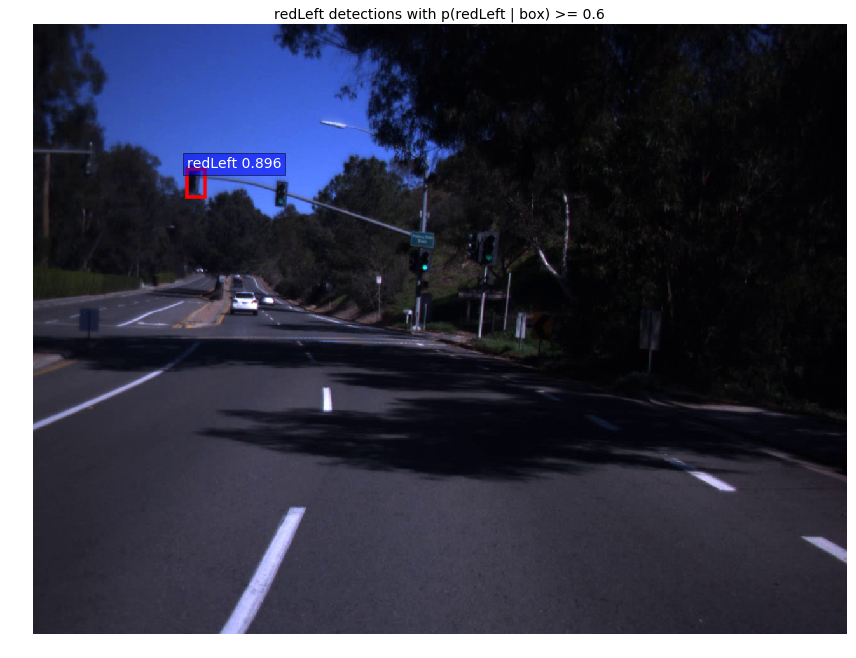

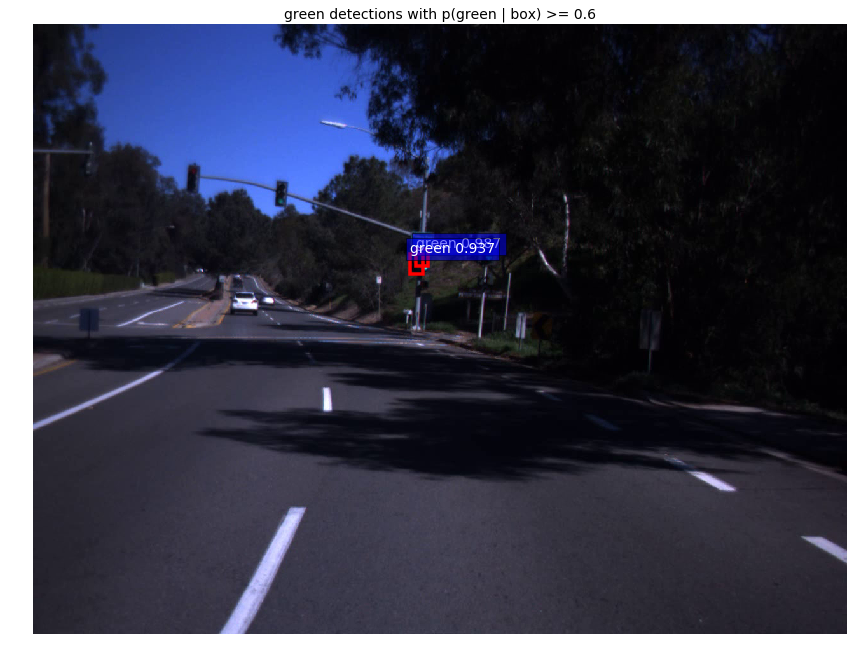

In [88]:
gpu_id = 3
caffe.set_mode_gpu()
caffe.set_device(gpu_id)
model_def = proj_root + 'models/viva/ZF/test.prototxt'
model_weights = proj_root + 'output/faster_rcnn_end2end/trainval/save/zf_faster_rcnn_iter_160000.caffemodel'
cfg.TEST.HAS_RPN = True
cfg.GPU_ID = gpu_id

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

im = 128 * np.ones((960, 1280, 3), dtype=np.uint8)
im_detect(net, im)

im_names = ['dayClip10--00010.png']
for im_name in im_names:
    print 'detection for data/demo/{}'.format(im_name)
    detection(net, im_name)

In [25]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [26]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 7, 7) (96,)
conv2	(256, 96, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 384, 3, 3) (384,)
conv5	(256, 384, 3, 3) (256,)
rpn_conv/3x3	(256, 256, 3, 3) (256,)
rpn_cls_score	(18, 256, 1, 1) (18,)
rpn_bbox_pred	(36, 256, 1, 1) (36,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
cls_score	(7, 4096) (7,)
bbox_pred	(28, 4096) (28,)


(256, 39, 51)


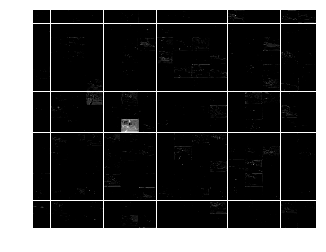

In [91]:
# the parameters are a list of [weights, biases]
# pool1_16 = sess.run(h_pool1, feed_dict={x:input_image})     # [16, 14, 14, 1]
#     pool1_reshape = sess.run(tf.reshape(pool1_16, [16, 1, 14, 14]))
#     fig4,ax4 = plt.subplots(nrows=1, ncols=16, figsize=(16,1))
#     for i in range(16):
#         ax4[i].imshow(pool1_reshape[i][0])
# filters = net.params['conv1'][0].data
# print  filters.shape
# filters_reshape = filters.transpose(0, 2, 3, 1)
# print filters_reshape.shape
# fig4,ax4 = plt.subplots(nrows=7, ncols=96, figsize=(96,7))
# for i in range(1):
#     ax4[i].imshow(filters_reshape[i][0])
# filters = net.params['conv5'][0].data[:,100]
# print filters.shape
# vis_square(filters)

feat = net.blobs['conv5'].data[0,:]
print feat.shape

vis_square(feat)
# print net.params['conv1'][0].data.shape
# print net.params['conv2'][0].data.shape